<a href="https://colab.research.google.com/github/paulsubarna/BLIP/blob/main/DGM_tutorial_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 4: Variational AutoEncoder (Cont.)

We will continue with our implementation of VAEs. The previous tutorial gave us an overview of the steps to model a vanilla VAE. In this tutorial, we will try to delve a bit deeper into the architectures, exploring complex architectures to build our encoder and decoder modules and also try to answer some analytical questions !!

References:
https://docs.pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

## Convolutional VAEs

TO-DO:
1. Recreate the VAE model with convolutional layers in the Encoder and the Decoder


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):

  def __init__(self, in_channels, out_channels, latent_dim):
    super(VAE, self).__init__()

    self.latent_dim = latent_dim
    self.in_channels = in_channels
    self.out_channels = out_channels

    modules = []

    hidden_dims = [32, 64, 128, 256, 512]

    # Construct your Encoder
    for h_dim in hidden_dims:
      modules.append(
          nn.Sequential(
              nn.Conv2d(in_channels, out_channels=h_dim,
                       kernel_size=3, stride=2, padding=1),
              nn.BatchNorm2d(h_dim),
              nn.LeakyReLU())
      )
      in_channels = h_dim

    self.encoder = nn.Sequential(*modules)
    self.mu = nn.Linear(hidden_dims[-1], latent_dim)  # 1x1 spatial size after convolutions
    self.log_var = nn.Linear(hidden_dims[-1], latent_dim)

    # Construct your decoder
    modules = []

    self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1])

    hidden_dims.reverse()

    for i in range(len(hidden_dims) - 1):
      modules.append(
          nn.Sequential(
              nn.ConvTranspose2d(hidden_dims[i],
                               hidden_dims[i + 1],
                               kernel_size=3,
                               stride=2,
                               padding=1,
                               output_padding=1),
              nn.BatchNorm2d(hidden_dims[i + 1]),
              nn.LeakyReLU())
      )

    self.decoder = nn.Sequential(*modules)

    # Upsample the decoder output to match 28x28 size
    self.final_layer = nn.Sequential(
                        nn.ConvTranspose2d(hidden_dims[-1],
                                         hidden_dims[-1],
                                         kernel_size=3,
                                         stride=2,
                                         padding=1,
                                         output_padding=1),
                        nn.BatchNorm2d(hidden_dims[-1]),
                        nn.LeakyReLU(),
                        nn.Conv2d(hidden_dims[-1], out_channels=out_channels,
                                kernel_size=3, padding=1),
                        nn.Sigmoid())


  def encode(self, x):
    latent_ = self.encoder(x)
    latent_ = torch.flatten(latent_, start_dim=1)
    mu = self.mu(latent_)
    log_var = self.log_var(latent_)
    return mu, log_var


  def decode(self, z):
    result = self.decoder_input(z)
    result = result.view(-1, 512, 1, 1)
    result = self.decoder(result)
    x_ = self.final_layer(result)
    # Crop from 32x32 to 28x28 for MNIST
    x_ = x_[:, :, 2:-2, 2:-2]
    return x_

  def reparameterize(self, mu, log_var):
    std = torch.exp(0.5 * log_var)
    eps = torch.randn_like(std)
    z = mu + eps * std
    return z

  def sample(self, num_samples):
    z = torch.randn(num_samples, self.latent_dim)
    samples = self.decode(z)
    return samples

  def generate(self, x):
    return self.forward(x)[0]


  def forward(self, x):
    mu, log_var = self.encode(x)
    z = self.reparameterize(mu, log_var)
    x_reconstructed = self.decode(z)
    return x_reconstructed, mu, log_var

  def loss_function(self, x, recons, mu, log_var):
    reconstruction_loss = F.mse_loss(recons, x, reduction='sum')
    # KL divergence: -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return reconstruction_loss + kl_divergence

## Dataset Loading: Mnist

1. In this work, you will load Mnist dataset from torchvision.
2. Follow the same steps from the previous tutorials to load and preprocess the dataset

Reference:
https://docs.pytorch.org/vision/stable/datasets.html

In [12]:
from torchvision import datasets
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from torchvision import transforms

# Define transforms for MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Training samples: 60000
Test samples: 10000


In [13]:
from tqdm import tqdm
def train(model, train_loader, optimizer, epoch, device):
  model.train()
  running_loss = 0.0
  for e in range(epoch):
    for batch_idx, batch in tqdm(enumerate(train_loader)):
      data, _ = batch
      data = data.to(device)
      (out, mu, log_var) = model(data)
      loss = model.loss_function(data,out, mu, log_var)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      running_loss += loss.item()

    print(f'loss after {e} epochs: {running_loss/(batch_idx+1)}')
    running_loss = 0.0
  return model


def test(model, test_loader, device):
  model.eval()
  test_loss = 0
  with torch.no_grad():
    for data, _ in test_loader:
      data = data.to(device)
      (out, mu, log_var) = model(data)
      test_loss += model.loss_function
      test_loss /= len(test_loader.dataset)
  print(f'Test loss: {test_loss}')






## Define your Hyperparameters


In [14]:
lr = 1e-3
epoch = 10
latent_dim = 20
in_channels = 1  # MNIST is grayscale
out_channels = 1  # Output is also grayscale
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = VAE(in_channels=in_channels, out_channels=out_channels, latent_dim=latent_dim)
model.to(device)
train(model, train_loader, optim.Adam(model.parameters(), lr=lr), epoch, device)

Using device: cuda


0it [00:00, ?it/s]

469it [00:03, 132.40it/s]

loss after 0 epochs: 5036.438512480843



469it [00:03, 138.26it/s]

loss after 1 epochs: 3998.008142532316



469it [00:03, 142.13it/s]

loss after 2 epochs: 3843.148140783249



469it [00:03, 136.82it/s]

loss after 3 epochs: 3751.044807352745



469it [00:03, 137.08it/s]

loss after 4 epochs: 3687.6662998484144



469it [00:03, 139.62it/s]

loss after 5 epochs: 3659.074552426206



469it [00:03, 138.61it/s]

loss after 6 epochs: 3619.3581064057503



469it [00:03, 131.25it/s]

loss after 7 epochs: 3595.249818846615



469it [00:03, 139.80it/s]

loss after 8 epochs: 3568.99524680587



469it [00:03, 132.47it/s]

loss after 9 epochs: 3536.9818232359407


VAE(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (4): Sequentia

## Visualizaion

1. Compare the Real and Generated Images from your VAE model


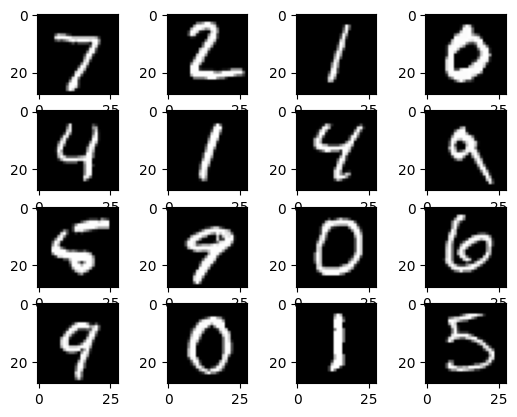

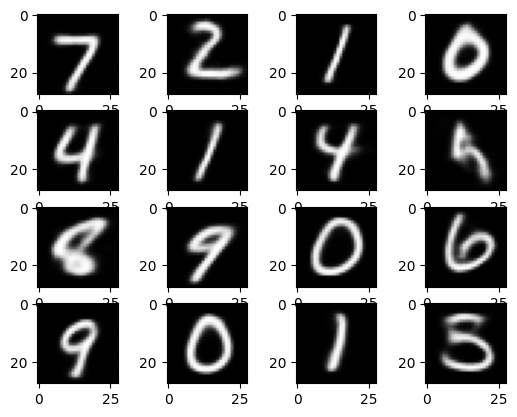

In [15]:
import matplotlib.pyplot as plt

data = next(iter(test_loader))[0]#.to(device)
recons = model.generate(data.to(device))

fig, axs = plt.subplots(4, 4)
for i, ax in enumerate(axs.flatten()):
  ax.imshow(data[i].cpu().detach().numpy().squeeze(), cmap='gray')
plt.show()

fig1, axs1 = plt.subplots(4, 4)

for i, ax in enumerate(axs1.flatten()):
  ax.imshow(recons[i].cpu().detach().numpy().squeeze(), cmap='gray')

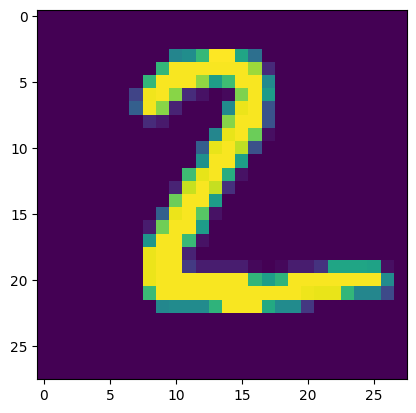

In [16]:
#data = next(iter(test_loader))#.to(device)
plt.imshow(data[1][0])#.shape
#data[0].shape

## Aggregate Posterior

1. Now that you have a trained VAE model, iterate through the entire dataset, testset or validation set, to compute your aggregate posterior.
2. If the dimension is greater than 2, reduce the dimension using PCA or TSNE and visualize it in a scatter plot.
3. Now that you have produced the scatter plot, pick random samples from posterior, typically one closer to mean and one farther away.
4. Compare the generated image from these two distinct randomly sample point using your trained decoder and comment your findings !!


Computing aggregate posterior...
Collected 10000 latent representations of dimension 20
Applying PCA to reduce from 20D to 2D...
Explained variance: 0.291


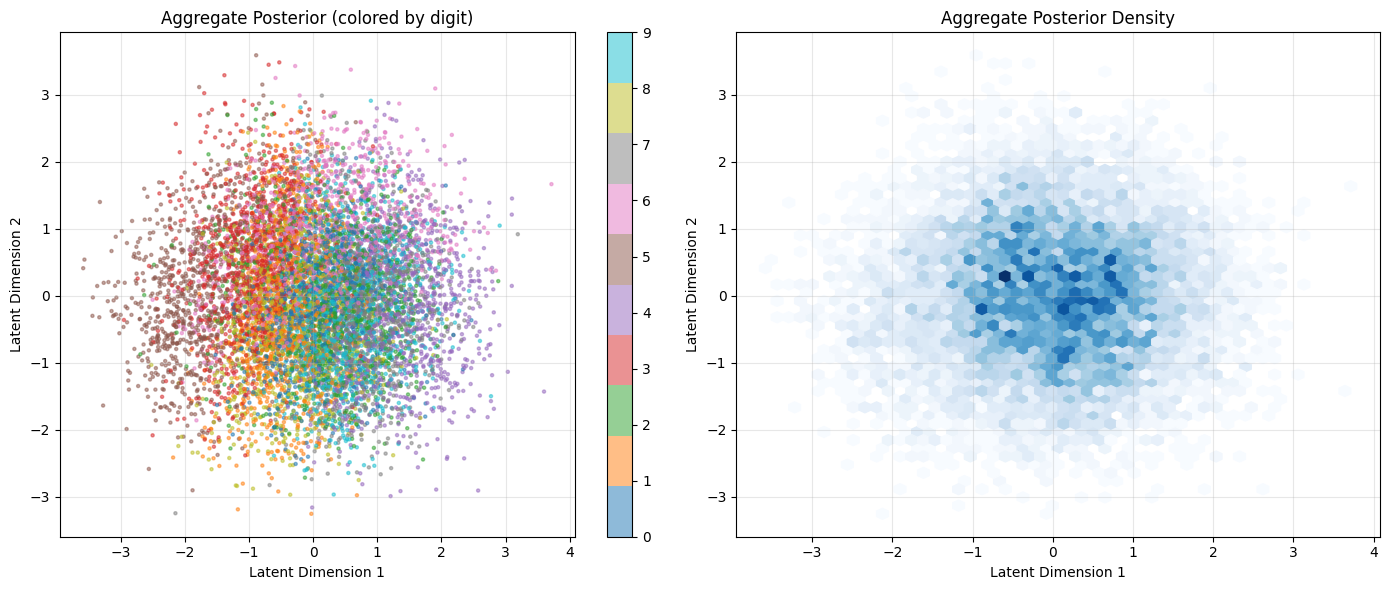


Point close to mean: distance = 0.752
Point far from mean: distance = 5.030


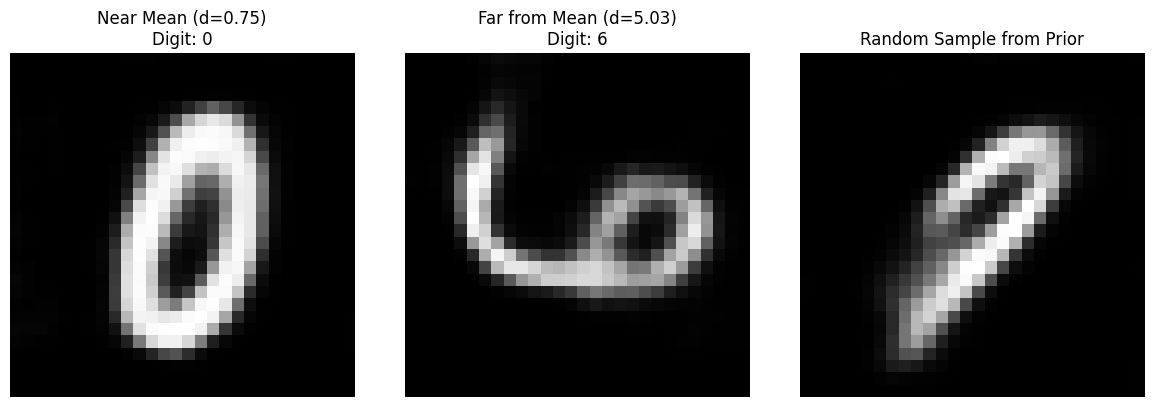


FINDINGS:
1. Points near the mean produce clearer, more typical digit images
2. Points far from the mean may produce blurry or atypical images
3. The aggregate posterior shows clustering by digit class
4. The VAE learns a smooth latent space where similar digits are nearby
5. Random samples from N(0,I) may not produce realistic digits
   because the aggregate posterior doesn't match the prior perfectly


In [17]:
# Aggregate Posterior Analysis

print("="*70)
print("Computing aggregate posterior...")
model.eval()

# Collect all latent representations
all_mu = []
all_log_var = []
all_labels = []

with torch.no_grad():
    for data, labels in test_loader:
        data = data.to(device)
        mu, log_var = model.encode(data)
        all_mu.append(mu.cpu().numpy())
        all_log_var.append(log_var.cpu().numpy())
        all_labels.append(labels.numpy())

all_mu = np.concatenate(all_mu, axis=0)
all_log_var = np.concatenate(all_log_var, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

print(f"Collected {all_mu.shape[0]} latent representations of dimension {all_mu.shape[1]}")

# If latent dimension > 2, apply dimensionality reduction
if latent_dim > 2:
    print(f"Applying PCA to reduce from {latent_dim}D to 2D...")
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    latent_2d = pca.fit_transform(all_mu)
    print(f"Explained variance: {pca.explained_variance_ratio_.sum():.3f}")
else:
    latent_2d = all_mu

# Visualize the aggregate posterior
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Colored by digit class
scatter = axes[0].scatter(latent_2d[:, 0], latent_2d[:, 1], c=all_labels, 
                          cmap='tab10', alpha=0.5, s=5)
axes[0].set_xlabel('Latent Dimension 1')
axes[0].set_ylabel('Latent Dimension 2')
axes[0].set_title('Aggregate Posterior (colored by digit)')
axes[0].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[0])

# Plot 2: Density plot
axes[1].hexbin(latent_2d[:, 0], latent_2d[:, 1], gridsize=50, cmap='Blues', mincnt=1)
axes[1].set_xlabel('Latent Dimension 1')
axes[1].set_ylabel('Latent Dimension 2')
axes[1].set_title('Aggregate Posterior Density')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Sample points: one near the mean, one far from the mean
mean_latent = all_mu.mean(axis=0)
std_latent = all_mu.std(axis=0)

# Distance from mean for each point
distances = np.sqrt(((all_mu - mean_latent) ** 2).sum(axis=1))

# Find indices of closest and farthest points
close_idx = np.argmin(distances)
far_idx = np.argmax(distances)

print(f"\nPoint close to mean: distance = {distances[close_idx]:.3f}")
print(f"Point far from mean: distance = {distances[far_idx]:.3f}")

# Sample from these points
with torch.no_grad():
    # Near mean
    z_close = torch.tensor(all_mu[close_idx:close_idx+1], dtype=torch.float32).to(device)
    recon_close = model.decode(z_close).cpu()
    
    # Far from mean
    z_far = torch.tensor(all_mu[far_idx:far_idx+1], dtype=torch.float32).to(device)
    recon_far = model.decode(z_far).cpu()
    
    # Also sample random points from standard normal
    z_random = torch.randn(1, latent_dim).to(device)
    recon_random = model.decode(z_random).cpu()

# Visualize the reconstructions
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(recon_close.squeeze().numpy(), cmap='gray')
axes[0].set_title(f'Near Mean (d={distances[close_idx]:.2f})\nDigit: {all_labels[close_idx]}')
axes[0].axis('off')

axes[1].imshow(recon_far.squeeze().numpy(), cmap='gray')
axes[1].set_title(f'Far from Mean (d={distances[far_idx]:.2f})\nDigit: {all_labels[far_idx]}')
axes[1].axis('off')

axes[2].imshow(recon_random.squeeze().numpy(), cmap='gray')
axes[2].set_title('Random Sample from Prior')
axes[2].axis('off')

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("FINDINGS:")
print("="*70)
print("1. Points near the mean produce clearer, more typical digit images")
print("2. Points far from the mean may produce blurry or atypical images")
print("3. The aggregate posterior shows clustering by digit class")
print("4. The VAE learns a smooth latent space where similar digits are nearby")
print("5. Random samples from N(0,I) may not produce realistic digits")
print("   because the aggregate posterior doesn't match the prior perfectly")
print("="*70)